In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
sc = StandardScaler()
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'

## Batter metrics

G: Games, AB: At Bats, R: Runs, H: Hits, 2B: Doubles, 3B: Triples, HR: Homeruns, RBI: Runs Batted In, SB: Stolen Bases, CS: Caught Stealing, BB: Base on Balls and SO: Strikeouts

## Pitcher metrics

G: Games, GS: Games Started, CG: Complete Games, SHO: Shutouts, SV: Saves, IPOuts: Outs Pitched (innings pitched x 3), H: Hits, ER: Earned Runs, HR: Homeruns, BB: Walks, SO: Strikeouts, BAOpp: Opponent's Batting Average



In [92]:
stats = pd.read_csv("data/player_stats.csv")
stats = stats.drop_duplicates(subset=["name", "age", "playerID", "yearID", "teamID"]).reset_index(drop=True)
stats["pitcher"] = [False if np.isnan(val) else True for val in stats.games_PIT]
batters = stats[stats.pitcher==False]
pitchers = stats[stats.pitcher==True]

In [93]:
teams = pd.read_csv("data/Teams.csv")
teams["winrate"] = [wins / (wins + losses) for wins, losses in zip(teams.W, teams.L)]
teams = teams[["yearID", "teamID", "Rank", "W", "L", "winrate"]]

In [94]:
batters = batters[["name", "age", "teamID", "playerID", "yearID", "weight", "height", "br_WAR_bat",
    "games_BAT", "at_bats_BAT", "runs_BAT", "doubles_BAT", "triples_BAT", "home_runs_BAT",
    "runs_batted_in_BAT", "stolen_bases_BAT", "caught_stealing_BAT", "strikeouts_BAT"]]

pitchers = pitchers[["name", "age", "teamID", "playerID", "yearID", "weight", "height", "br_WAR_pit",
    "games_PIT", "games_started_PIT", "complete_games_PIT", "shutouts_PIT", "saves_PIT", "outs_pitched_PIT",
    "outs_pitched_PIT", "hits_allowed_PIT", "earned_runs_PIT", "home_runs_allowed_PIT", "walks_PIT",
    "strikeouts_PIT", "opponent_batting_average_PIT"]]

batters = batters.fillna(np.nan)
pitchers = pitchers.fillna(np.nan)

In [95]:
X_bat = batters[["games_BAT", "at_bats_BAT", "runs_BAT", "doubles_BAT", "triples_BAT", "home_runs_BAT",
    "runs_batted_in_BAT", "stolen_bases_BAT", "caught_stealing_BAT", "strikeouts_BAT"]].values
X_pit = pitchers[["games_PIT", "games_started_PIT", "complete_games_PIT", "shutouts_PIT", "saves_PIT", "outs_pitched_PIT",
    "outs_pitched_PIT", "hits_allowed_PIT", "earned_runs_PIT", "home_runs_allowed_PIT", "walks_PIT",
    "strikeouts_PIT", "opponent_batting_average_PIT"]].values

In [96]:
def perform_pca(X):

    imputed_values = imputer.fit_transform(X)
    scaled_values = sc.fit_transform(imputed_values)

    pca = PCA(n_components=5)
    output = pca.fit_transform(scaled_values)
    variance = pca.explained_variance_ratio_

    return output, variance

In [100]:
output_bat, variance_bat = perform_pca(X_bat)
output_pit, variance_pit = perform_pca(X_pit)

In [118]:
def elbow_plot(var, type, ax):

    components = list(range(1, len(var)+1))

    ax.plot(components, var, color="black")
    ax.scatter(components, var, color="r")
    ax.set_ylim([0, .75])
    ax.set_facecolor("white")
    ax.set_xlabel('Component', fontsize=14)
    ax.set_ylabel("Variance Explained", fontsize=14)
    if type=="batter":
        ax.set_title('Variance Explained by Component for Batters', fontsize=16)
    else:
        ax.set_title('Variance Explained by Component for Pitchers', fontsize=16)

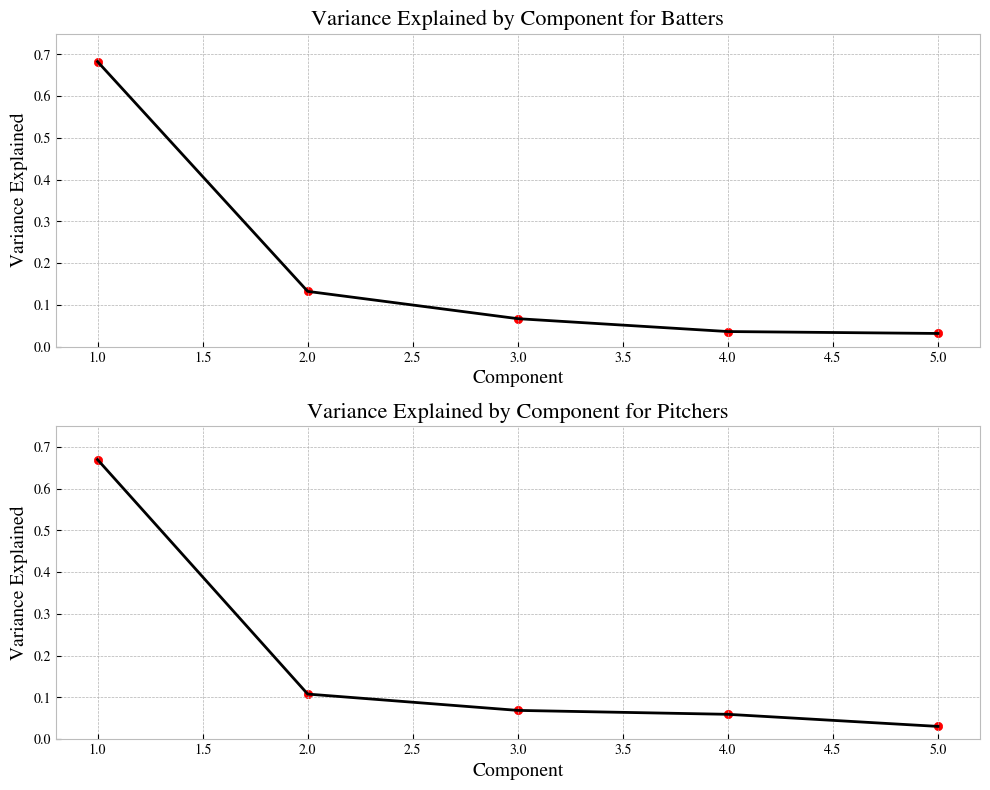

In [119]:
plt.style.use('bmh')
fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax1, ax2 = ax

elbow_plot(variance_bat, type="batter", ax=ax1)
elbow_plot(variance_pit, type="pitcher", ax=ax2)

plt.tight_layout()


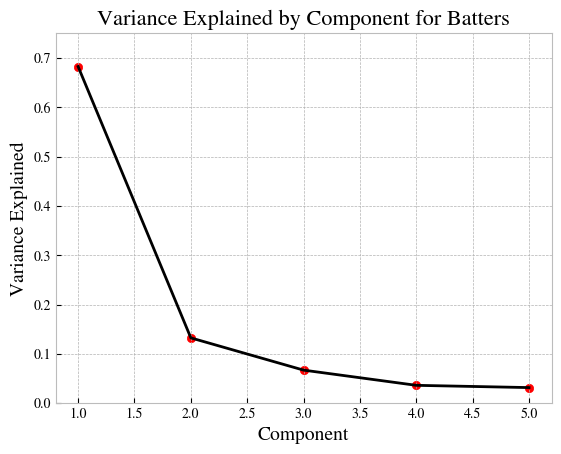

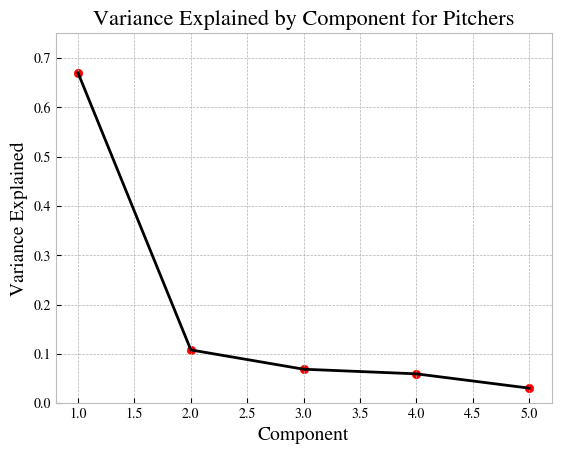

In [102]:
elbow_plot(variance_bat, type="batter")
elbow_plot(variance_pit, type="pitcher")

In [106]:
batters["component_1"], batters["component_2"], _, _, _ = zip(*output_bat)
batters["prev_comp1"] = batters.groupby("playerID")["component_1"].shift(1)
batters["prev_comp2"] = batters.groupby("playerID")["component_2"].shift(1)

pitchers["component_1"], pitchers["component_2"], _, _, _ = zip(*output_pit)
pitchers["prev_comp1"] = pitchers.groupby("playerID")["component_1"].shift(1)
pitchers["prev_comp2"] = pitchers.groupby("playerID")["component_2"].shift(1)

In [107]:
batters["prev_comp1"], batters["prev_comp2"] = zip(*imputer.fit_transform(batters[["prev_comp2", "prev_comp2"]]))
pitchers["prev_comp1"], pitchers["prev_comp2"] = zip(*imputer.fit_transform(pitchers[["prev_comp2", "prev_comp2"]]))

In [108]:
batters_grouped = batters.groupby(["teamID", "yearID"]).mean()

In [109]:
merged = batters_grouped.merge(teams, on=["yearID", "teamID"])

In [110]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(merged[["prev_comp1", "prev_comp2"]], merged[["Rank"]])

/Users/bertram/.pyenv/versions/3.10.0/envs/stats/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=0)

In [111]:
merged["prediction"] = classifier.predict(merged[["prev_comp1", "prev_comp2"]])
merged["correct"] = [True if pred in [rank-1, rank, rank+1] else False for pred, rank in zip(merged.prediction, merged.Rank)]

In [112]:
merged.correct.value_counts()

False    332
True     271
Name: correct, dtype: int64

## Visualization

In [ ]:
import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [88]:
def elbow_plot(var, type):

    components = list(range(1, len(var)+1))

    plt.style.use('bmh')
    fig, ax = plt.subplots()
    plt.plot(components, var, color="black")
    plt.scatter(components, var, color="r")
    ax.set_ylim([0, .75])
    ax.set_facecolor("white")
    ax.set_xlabel('Component', fontsize=14)
    ax.set_ylabel("Variance Explained", fontsize=14)
    if type=="batter":
        ax.set_title('Variance Explained by Component for Batters', fontsize=16)
    else:
        ax.set_title('Variance Explained by Component for Pitchers', fontsize=16)